In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import regex as re
import json
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mauib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
STOPWORDS = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
USERNAME_RE = re.compile('@[^\s]+')
HASHTAG_RE = re.compile('#[^\s]+')

VOCAB_SIZE = 10000
TEXT_MAX_LEN = 200
TRUNCATING_TYPE = PADDING_TYPE = 'post'
OOV_TOK = '<OOV>'

In [31]:
# data pre processing

texts = []
labels = []

df = pd.read_csv('DATASET_2.csv', names=['label', 'text'])
df = df.sample(frac=1).reset_index(drop=True)

for index, row in df.iterrows():
    if 'http' in str(row['text']) or str(row['label']) == 'nan': continue

    labels.append(str(row['label']))
    
    txt = str(row['text']).lower()
    txt = USERNAME_RE.sub('', txt)
    txt = REPLACE_BY_SPACE_RE.sub(' ', txt)
    txt = BAD_SYMBOLS_RE.sub(' ', txt)
    txt = ' '.join(word for word in txt.split() if word not in STOPWORDS)

    texts.append(txt)

print(len(texts), len(labels))

27101 27101


In [32]:
# data splitting
TRAIN_SIZE = int(len(texts) * .8)

training_labels = labels[0:TRAIN_SIZE]
training_texts = texts[0:TRAIN_SIZE]

testing_labels = labels[TRAIN_SIZE:]
testing_texts = texts[TRAIN_SIZE:]

print(len(training_labels), len(training_texts))
print(len(testing_labels), len(testing_texts))

21680 21680
5421 5421


In [33]:
# tokenizing texts
text_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n')
text_tokenizer.fit_on_texts(testing_texts)

training_texts_sequence = text_tokenizer.texts_to_sequences(training_texts)
training_texts_padded = pad_sequences(training_texts_sequence, maxlen=TEXT_MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

testing_texts_sequence = text_tokenizer.texts_to_sequences(testing_texts)
testing_texts_padded = pad_sequences(testing_texts_sequence, maxlen=TEXT_MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

# tokenizing labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_labels_sequence = np.array(label_tokenizer.texts_to_sequences(training_labels))
testing_labels_sequence = np.array(label_tokenizer.texts_to_sequences(testing_labels))

print(len(training_labels_sequence), len(training_texts_padded))
print(training_labels_sequence[:10], training_labels[:10])

print(set(labels))

21680 21680
[[1]
 [2]
 [4]
 [1]
 [2]
 [4]
 [2]
 [1]
 [2]
 [1]] ['cyberbullying', 'suicide', 'nsfw', 'cyberbullying', 'suicide', 'nsfw', 'suicide', 'cyberbullying', 'suicide', 'cyberbullying']
{'cyberbullying', 'nsfw', 'suicide', 'neutral'}


In [34]:
# creating the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(text_tokenizer.word_index), 64, input_length=TEXT_MAX_LEN),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 64)           748160    
                                                                 
 dropout_9 (Dropout)         (None, 200, 64)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                      

In [35]:
# training model
num_epochs = 10
history = model.fit(training_texts_padded, training_labels_sequence, epochs=num_epochs, validation_data=(testing_texts_padded, testing_labels_sequence), verbose=1)
test_loss, test_accuracy = model.evaluate(testing_texts_padded, testing_labels_sequence)

print(f'Loss: {test_loss}, Accuracy: {test_accuracy}')

Epoch 1/10
678/678 [==============================] - 136s 195ms/step - loss: 0.9666 - accuracy: 0.5825 - val_loss: 0.6379 - val_accuracy: 0.7384
Epoch 2/10
678/678 [==============================] - 138s 204ms/step - loss: 0.6091 - accuracy: 0.7712 - val_loss: 0.5455 - val_accuracy: 0.7908
Epoch 3/10
678/678 [==============================] - 139s 204ms/step - loss: 0.4901 - accuracy: 0.8235 - val_loss: 0.5570 - val_accuracy: 0.7945
Epoch 4/10
678/678 [==============================] - 144s 212ms/step - loss: 0.4313 - accuracy: 0.8459 - val_loss: 0.5685 - val_accuracy: 0.7928
Epoch 5/10
678/678 [==============================] - 141s 207ms/step - loss: 0.3938 - accuracy: 0.8618 - val_loss: 0.5727 - val_accuracy: 0.7958
Epoch 6/10
678/678 [==============================] - 145s 213ms/step - loss: 0.3635 - accuracy: 0.8730 - val_loss: 0.5799 - val_accuracy: 0.7945
Epoch 7/10
678/678 [==============================] - 147s 217ms/step - loss: 0.3379 - accuracy: 0.8808 - val_loss: 0.6329 -

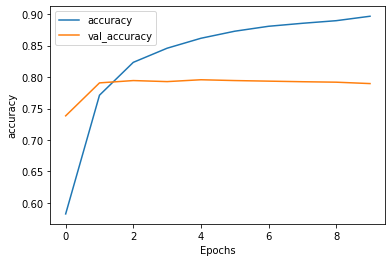

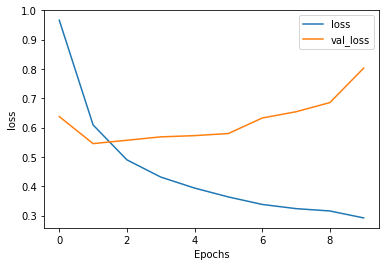

In [36]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [37]:
# saving model
model.save('model.h5')

# saving vocabs
json.dump(text_tokenizer.word_index, open('vocabs.txt', 'w'))

tf.keras.backend.clear_session()

In [38]:
# testing to get a prediction
entry = ['you are a piece of shit']
entry_sequence = text_tokenizer.texts_to_sequences(entry)
entry_padded = pad_sequences(entry_sequence, maxlen=TEXT_MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
print(entry_padded)
prediction = model.predict(entry_padded)
labels = ['suicide', 'cyberbullying', 'neutral', 'nsfw']
print(prediction, labels[np.argmax(prediction)-1])

[[4181 6419 4823  567    1   46    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   